In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.utils import resample
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# Optional: SMOTE for imbalance handling
try:
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True
    print("SMOTE available for oversampling.")
except ImportError:
    SMOTE_AVAILABLE = False
    print("SMOTE not available. Using undersampling.")

# Plotting setup
plt.style.use('default')
sns.set_palette("husl")

# Ensure images folder exists
os.makedirs('images', exist_ok=True)
print("Project setup complete. Ready to load data.")

SMOTE available for oversampling.
Project setup complete. Ready to load data.


Loading creditcard.csv...
Dataset shape: (284807, 31)

First 5 rows:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.7982

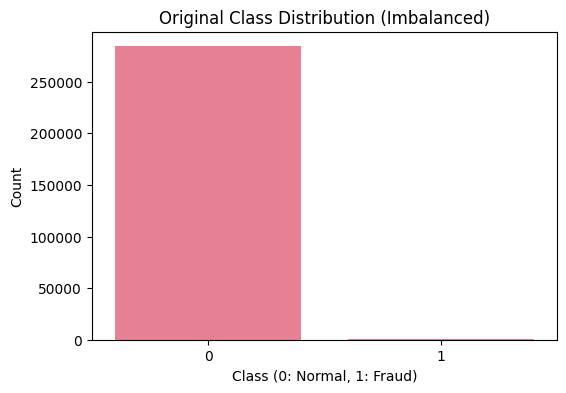

In [2]:
# Load dataset
print("Loading creditcard.csv...")
df = pd.read_csv('creditcard.csv')

# Exploration: head, info, describe, missing values
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nDescription (selected features):")
print(df[['Amount', 'V2', 'V3', 'V4', 'Class']].describe())
print("\nMissing values:")
print(df.isnull().sum())

# Class distribution (highly imbalanced)
print("\nClass distribution:")
print(df['Class'].value_counts())

# Plot original class distribution and save
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df)
plt.title('Original Class Distribution (Imbalanced)')
plt.xlabel('Class (0: Normal, 1: Fraud)')
plt.ylabel('Count')
plt.savefig('images/class_distribution_original.png', dpi=300, bbox_inches='tight')
plt.show()

Selected features: ['Amount', 'V2', 'V3', 'V4']
Features scaled (mean=0, std=1).
Applying SMOTE (oversampling minority)...
Resampled shape: (568630, 4)
Resampled class distribution:
Class
0    284315
1    284315
Name: count, dtype: int64


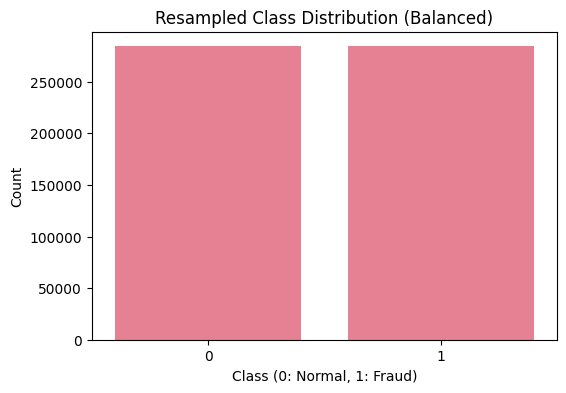

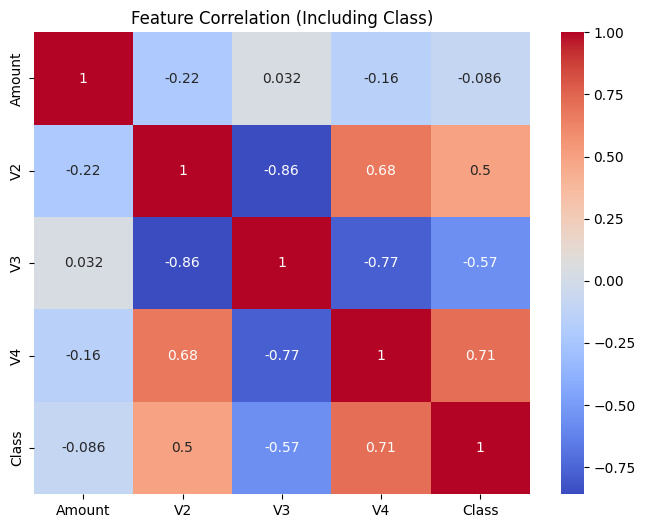

Scaler saved to scaler.pkl


In [3]:
# Select features: Amount, V2, V3, V4
features = ['Amount', 'V2', 'V3', 'V4']
X = df[features].copy()
y = df['Class'].copy()

print(f"Selected features: {features}")

# Preprocess Amount (log transform for skew)
X['Amount'] = np.log(X['Amount'] + 1)

# Scaling with StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Features scaled (mean=0, std=1).")

# Handle imbalance: SMOTE if available, else undersample
if SMOTE_AVAILABLE:
    print("Applying SMOTE (oversampling minority)...")
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
else:
    print("Undersampling majority class...")
    majority = df[df['Class'] == 0]
    minority = df[df['Class'] == 1]
    majority_down = resample(majority, replace=False, n_samples=len(minority), random_state=42)
    df_resampled = pd.concat([majority_down, minority])
    X_resampled = scaler.fit_transform(df_resampled[features])
    y_resampled = df_resampled['Class']

print(f"Resampled shape: {X_resampled.shape}")
print("Resampled class distribution:")
print(pd.Series(y_resampled).value_counts())

# Plot resampled class distribution and save
plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled)
plt.title('Resampled Class Distribution (Balanced)')
plt.xlabel('Class (0: Normal, 1: Fraud)')
plt.ylabel('Count')
plt.savefig('images/class_distribution_resampled.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot feature correlation heatmap and save
plt.figure(figsize=(8, 6))
corr_data = pd.DataFrame(X_resampled, columns=features)
corr_data['Class'] = y_resampled
sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation (Including Class)')
plt.savefig('images/feature_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

# Save scaler early
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Scaler saved to scaler.pkl")

In [4]:
# 80/20 split, stratified for balance
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train class dist: {np.bincount(y_train)}")
print(f"Test class dist: {np.bincount(y_test)}")

Train shape: (454904, 4), Test shape: (113726, 4)
Train class dist: [227452 227452]
Test class dist: [56863 56863]


In [7]:
# Network architecture: Input (4) -> Hidden (8) -> Output (1 for binary)
input_size = X_train.shape[1]  # 4
hidden_size = 8  # Tunable, approx input*2
output_size = 1

# Activation functions (sigmoid for binary classification)
def sigmoid(z):
    """Sigmoid activation function."""
    z = np.clip(z, -250, 250)  # Prevent overflow
    return 1 / (1 + np.exp(-z))

def sigmoid_grad(z):
    """Derivative of sigmoid."""
    s = sigmoid(z)
    return s * (1 - s)

# Initialize weights with epsilon (small random values)
def initialize_weights(input_size, hidden_size, output_size):
    """Initialize weights including bias columns."""
    np.random.seed(42)
    epsilon = 0.12
    W1 = np.random.rand(hidden_size, input_size + 1) * 2 * epsilon - epsilon  # +1 for bias
    W2 = np.random.rand(output_size, hidden_size + 1) * 2 * epsilon - epsilon
    return W1, W2

# Forward propagation (with bias handling)
def forward_prop(X, W1, W2):
    """Forward pass: Compute Z and A for each layer."""
    m = X.shape[0]
    # Add bias column to input (column of 1s)
    X_bias = np.c_[np.ones(m), X]
    Z1 = X_bias @ W1.T
    A1 = sigmoid(Z1)
    # Add bias to hidden layer output
    A1_bias = np.c_[np.ones(m), A1]
    Z2 = A1_bias @ W2.T
    A2 = sigmoid(Z2)
    return Z1, A1, Z2, A2, X_bias, A1_bias

# Compute cost (binary cross-entropy + L2 regularization)
def compute_cost(A2, y, W1, W2, lambda_=0.01):
    """Binary cross-entropy cost with regularization (exclude bias)."""
    m = y.shape[0]
    # Binary cost
    cost = -1/m * np.sum(y * np.log(A2 + 1e-15) + (1 - y) * np.log(1 - A2 + 1e-15))
    # L2 regularization (exclude bias columns)
    reg = lambda_ / (2 * m) * (np.sum(W1[:, 1:]**2) + np.sum(W2[:, 1:]**2))
    return cost + reg

# Backward propagation (compute gradients)
# Backward propagation (compute gradients) - CORRECTED VERSION
def backprop(X, y, Z1, A1, Z2, A2, W1, W2, X_bias, A1_bias, lambda_=0.01):
    """Backward pass: Compute deltas and gradients with regularization."""
    m = y.shape[0]
    # Output layer delta (m, 1)
    dZ2 = A2 - y.reshape(-1, 1)
    # Gradient for W2: (1/m) * (dZ2.T @ A1_bias) to get (1, 9) matching W2
    dW2 = (1 / m) * (dZ2.T @ A1_bias)
    # Regularization for W2 (exclude bias column)
    dW2[:, 1:] += (lambda_ / m) * W2[:, 1:]

    # Hidden layer delta: Propagate error back
    dA1 = dZ2 @ W2  # (m, 1) @ (1, 9) = (m, 9)
    dZ1 = dA1[:, 1:] * sigmoid_grad(Z1)  # (m, 8) - exclude bias part
    # Gradient for W1: (1/m) * (dZ1.T @ X_bias) to get (8, 5) matching W1
    dW1 = (1 / m) * (dZ1.T @ X_bias)
    # Regularization for W1 (exclude bias column)
    dW1[:, 1:] += (lambda_ / m) * W1[:, 1:]

    return dW1, dW2

# Predict function
def predict(X, W1, W2):
    """Predict classes using threshold 0.5."""
    _, _, _, A2, _, _ = forward_prop(X, W1, W2)
    return (A2 > 0.5).astype(int).flatten()

print("Neural network functions defined. Architecture: Input(4) -> Hidden(8) -> Output(1)")

Neural network functions defined. Architecture: Input(4) -> Hidden(8) -> Output(1)


Training Neural Network (Mini-batch Gradient Descent)...
Epoch 1/60, Avg Cost: 177.8705
Epoch 6/60, Avg Cost: 177.6363
Epoch 12/60, Avg Cost: 177.5857
Epoch 18/60, Avg Cost: 177.6772
Epoch 24/60, Avg Cost: 177.9520
Epoch 30/60, Avg Cost: 178.5207
Epoch 36/60, Avg Cost: 179.5182
Epoch 42/60, Avg Cost: 181.0717
Epoch 48/60, Avg Cost: 183.2506
Epoch 54/60, Avg Cost: 186.1055
Epoch 60/60, Avg Cost: 189.6079
Training completed!


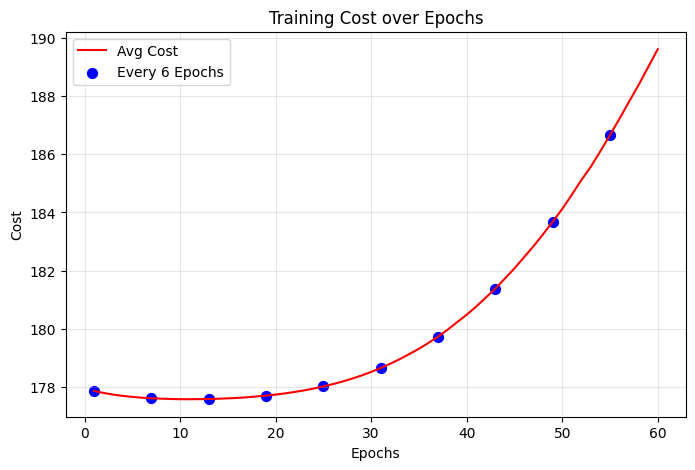

In [13]:
# Training parameters: Mini-batch gradient descent
epochs = 60
batch_size = 256
learning_rate = 0.0001  # LOWERED to 0.0001 for stable sigmoid descent
lambda_ = 0.01
clip_norm = 1.0  # Gradient clipping to prevent explosion
costs = []  # Average costs per epoch

# Initialize weights
W1, W2 = initialize_weights(input_size, hidden_size, output_size)
y_train = y_train if isinstance(y_train, np.ndarray) else y_train.values  # Ensure numpy array

print("Training Neural Network (Mini-batch Gradient Descent)...")

m = X_train.shape[0]
for epoch in range(epochs):
    # Shuffle data
    perm = np.random.permutation(m)
    X_shuf = X_train[perm]
    y_shuf = y_train[perm]
    
    epoch_cost = 0  # Accumulate for average
    
    # Mini-batches
    for i in range(0, m, batch_size):
        X_batch = X_shuf[i:i+batch_size]
        y_batch = y_shuf[i:i+batch_size]
        
        # Forward propagation
        Z1, A1, Z2, A2, X_bias, A1_bias = forward_prop(X_batch, W1, W2)
        
        # Compute cost (accumulate)
        batch_cost = compute_cost(A2, y_batch, W1, W2, lambda_)
        epoch_cost += batch_cost
        
        # Backward propagation and update
        dW1, dW2 = backprop(X_batch, y_batch, Z1, A1, Z2, A2, W1, W2, X_bias, A1_bias, lambda_)
        
        # Gradient clipping (optional, for stability)
        grad_norm1 = np.linalg.norm(dW1)
        grad_norm2 = np.linalg.norm(dW2)
        if grad_norm1 > clip_norm:
            dW1 *= clip_norm / grad_norm1
        if grad_norm2 > clip_norm:
            dW2 *= clip_norm / grad_norm2
        
        W1 -= learning_rate * dW1
        W2 -= learning_rate * dW2
    
    # Average cost for epoch
    avg_cost = epoch_cost / (m / batch_size)  # Number of batches
    costs.append(avg_cost)
    
    # Track and print cost every 10% of epochs (every 6 epochs)
    if (epoch + 1) % 6 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs}, Avg Cost: {avg_cost:.4f}")

print("Training completed!")

# Plot training cost and save
# Plot training cost and save (FULL CURVE)
plt.figure(figsize=(8, 5))
full_epochs = list(range(1, len(costs) + 1))  # 1 to 60 for all costs
plt.plot(full_epochs, costs, label='Avg Cost', color='red')
# Optional: Mark every 6th point
every6 = full_epochs[::6]
costs_every6 = costs[::6]
plt.scatter(every6, costs_every6, color='blue', marker='o', s=50, label='Every 6 Epochs')
plt.title('Training Cost over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('images/training_cost.png', dpi=300, bbox_inches='tight')
plt.show()

Confusion Matrix:
[[55170  1693]
 [10711 46152]]


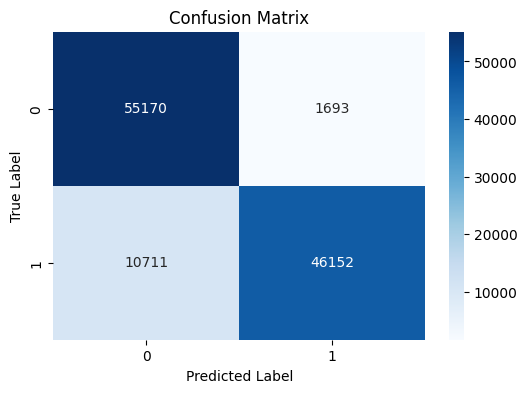


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90     56863
           1       0.96      0.81      0.88     56863

    accuracy                           0.89    113726
   macro avg       0.90      0.89      0.89    113726
weighted avg       0.90      0.89      0.89    113726


ROC AUC Score: 0.9603
Test Accuracy: 89.09%


In [14]:
# Predictions on test set
y_pred = predict(X_test, W1, W2)
# Probabilities for AUC
_, _, Z2, A2, _, _ = forward_prop(X_test, W1, W2)
y_proba = A2.flatten()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot and save confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('images/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC AUC Score
auc = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {auc:.4f}")

# Overall Accuracy
acc = (y_pred == y_test).mean() * 100
print(f"Test Accuracy: {acc:.2f}%")

In [16]:
# Save trained weights and metadata
model_data = {
    'W1': W1,
    'W2': W2,
    'input_size': input_size,
    'hidden_size': hidden_size,
    'output_size': output_size
}
np.savez('model_weights.npz', **model_data)

# Scaler already saved in Cell 3, but confirm
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model saved: model_weights.npz (weights) and scaler.pkl")

# Optional: Quick load test
loaded = np.load('model_weights.npz')
print(f"Loaded W1 shape: {loaded['W1'].shape}")
print("Project complete! Check 'images/' for plots and outputs for model files.")

Model saved: model_weights.npz (weights) and scaler.pkl
Loaded W1 shape: (8, 5)
Project complete! Check 'images/' for plots and outputs for model files.


In [17]:
# Load model
loaded = np.load('model_weights.npz')
W1 = loaded['W1']
W2 = loaded['W2']

# New data example (scale first)
new_X = scaler.transform([[np.log(100) + 1, 0.5, -0.5, 1.0]])  # Dummy
pred = predict(new_X, W1, W2)
print(f"Prediction (0=normal, 1=fraud): {pred[0]}")

Prediction (0=normal, 1=fraud): 0
